In [1]:
%matplotlib inline
import pandas as pd
from scipy.integrate import cumtrapz
import numpy as np
import matplotlib.pyplot as plt
import RecreateBiryukov

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 1 to 2524
Data columns (total 18 columns):
NAME          308 non-null object
F0            308 non-null float64
F0_err        308 non-null float64
F1            308 non-null float64
F1_err        308 non-null float64
F2            308 non-null float64
F2_err        308 non-null float64
P0            308 non-null float64
P0_err        308 non-null float64
P1            308 non-null float64
P1_err        308 non-null float64
BINARY        0 non-null object
TYPE          54 non-null object
AGE           308 non-null float64
F2_rel_err    308 non-null float64
nobs          308 non-null float64
tch           308 non-null float64
tch_years     308 non-null float64
dtypes: float64(15), object(3)
memory usage: 45.7+ KB
None


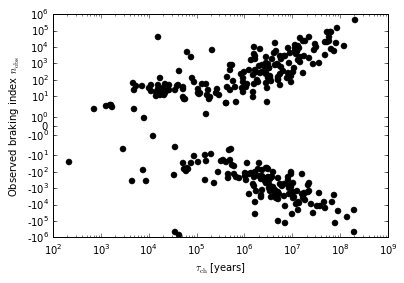

In [2]:
df = RecreateBiryukov.GetData()
tch = df['tch']
nobs = df['nobs']
RecreateBiryukov.NobsPlot(df)
plt.show()

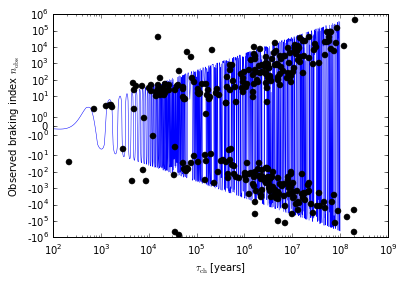

In [18]:
def SignalModel(tauAge, params):

    theta, chi, tauP = params
    psi = 2*np.pi*tauAge/tauP
    return 2*tauAge*np.pi*theta * np.cos(psi) * (np.cos(chi)/np.sin(chi)) / tauP

ax = RecreateBiryukov.NobsPlot(df)
time = np.logspace(2, 8, 1000)
theta, chi, tauP = 1.1, 2.1, 1e3
ax.semilogx(time, SignalModel(time, [theta, chi, tauP]), lw=0.5, zorder=-1)
plt.show()

In [20]:
import emcee 
import triangle
import BDATools as BDA

def Generic_lnuniformprior(theta, theta_lims):
    """ Generic uniform priors on theta 
    
    Parameters
    ----------
    theta : array_like 
        Value of the parameters
    theta_lims: array_like of shape (len(theta), 2)
        Array of pairs [min, max] for each theta paramater
        
    """
    
    theta_lims = np.array(theta_lims)
    
    if all(theta - theta_lims[:, 0] > 0 ) and all(theta_lims[:, 1] - theta > 0):
        return np.prod(1.0/np.diff(theta_lims, axis=1))
    return -np.inf

def Generic_lnlike(theta, t, x, model):
    """ Generic likelihood function for signal in Gaussian noise
    
    Parameters
    ----------
    theta : array_like
        Value of the parameters, the noise strength `sigma` should ALWAYS be
        the last element in the list
    t : array_like
        The independant variable
    x : array_like
        The observed dependent variable
    model : func
        Signal model, calling `model(theta[:-1], t)` should
        produced the corresponding value of the signal 
        alone `x_val`, without noise. 
    
    """
    
    sigma2 = theta[-1]**2
    xmod = [model(ti, theta[:-1]) for ti in t]
    return -0.5*(np.sum((np.abs(x)-np.abs(xmod))**2 / sigma2 + np.log(2*np.pi*sigma2))) 
 

logl = lambda theta, x, y: Generic_lnlike(theta, x, y, SignalModel)     

# Prior
theta_lims = [[0.0, 0.1], 
              [0, np.pi],
              [0, 1e12],
              [0, 1e8]
              ]

symbols = ['theta', 'chi', 'tauP', 'sigma']
logp = lambda theta: Generic_lnuniformprior(theta, theta_lims)   

Run zeroth burn-in of 1000 points to sample from
Plotting temperature 0 chains
Resample from zeroth burn-in
Running burn-in of 1000 points and prod of 1000 points
Running seriel MCMC simulation
Plotting temperature 0 chains


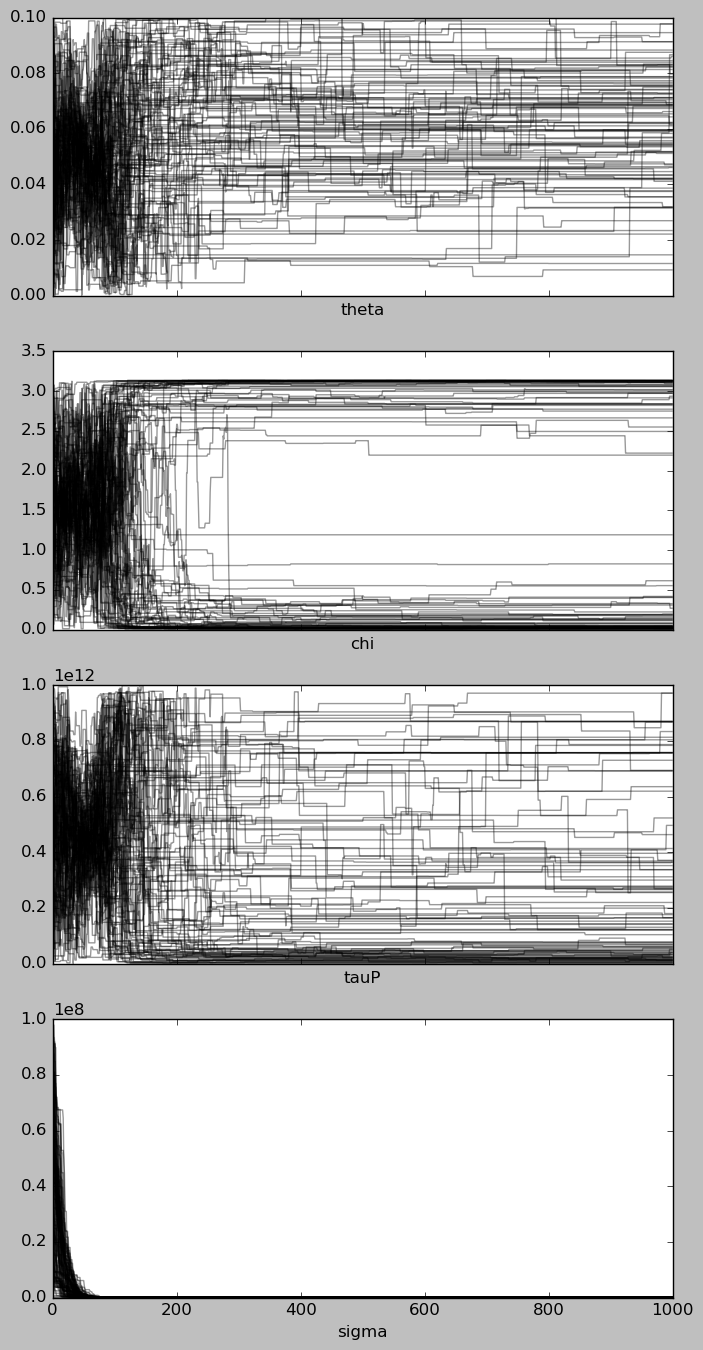

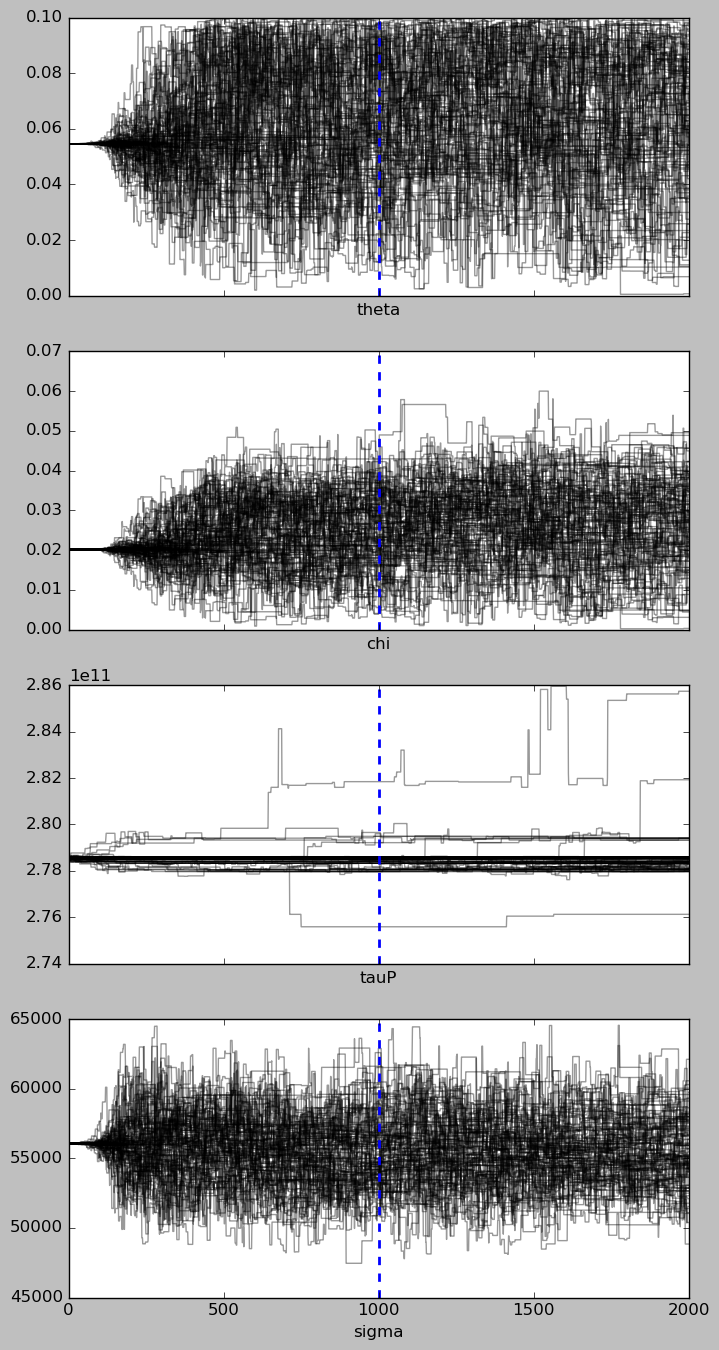

In [25]:
ntemps = 1
nburn0 = 1000
nburn = 1000
nprod = 1000
ndim = 4
nwalkers = 100
scatter_val = 1e-4

# Initialise the walkers
p0 = [[[np.random.uniform(tl[0], tl[1]) for tl in theta_lims] 
               for i in range(nwalkers)] for k in range(ntemps)]

# Run the sampler
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, logl, logp, loglargs=[tch, nobs])
sampler.use_parallel = False

BDA.MCMCMethod(sampler, p0, nwalkers, nprod, nburn, nburn0, symbols, True, scatter_val, ndim)

plt.show()

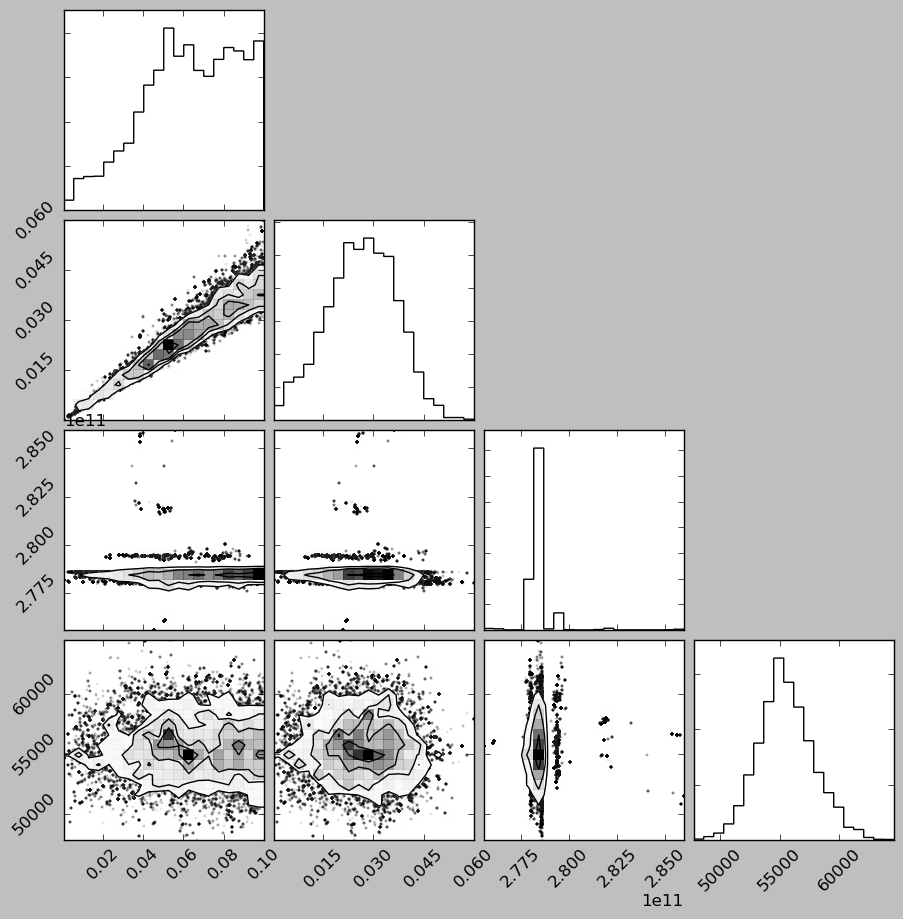

In [28]:
nburn=1000
samples = sampler.chain[:, :, nburn:, :].reshape((-1, ndim))
triangle.corner(samples)
plt.show()

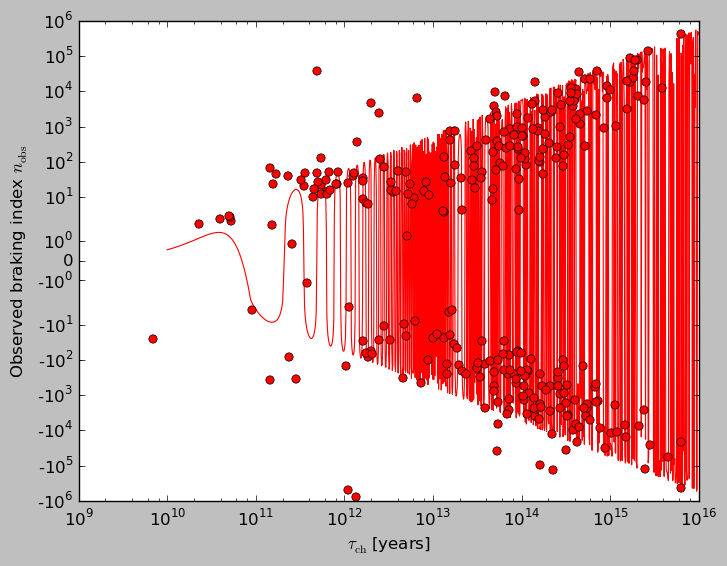

In [27]:
fig, ax = plt.subplots()

ax.set_yscale("symlog")
ax.set_xlabel(r"$\tau_{\mathrm{ch}}$ [years]")
ax.set_ylabel(r"Observed braking index $n_{\mathrm{obs}}$")
ax.semilogx(tch, nobs, "or")

samples = sampler.chain[:, :, nburn:, :].reshape((-1, ndim))
x_sim_plot = np.logspace(10, 16, 1000) 
for s in samples[np.random.randint(len(samples), size=1)]:
    ysignal = np.array([SignalModel(xs, s[:-1]) for xs in x_sim_plot])
    ax.plot(x_sim_plot, ysignal, "-", label="model",
            color='r', lw=0.8, alpha=1.0, zorder=-1
            )
    #ax.plot(x_sim_plot, -ysignal, "--k", label="model",
    #        color='b', lw=0.8, alpha=1.0
    #        )
    #noise_low = ysignal - s[-1]
    #noise_high = ysignal + s[-1]
    #ax.fill_between(x_sim_plot, noise_low,
    #                noise_high, color='k', alpha=0.01)
        
plt.show()